In [ ]:
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import os
import pandas as pd


# ✅  initialize_fcm_state_fuzzy



In [ ]:
import networkx as nx

# Load the graph from the file
all_network = nx.read_graphml('/content/all_network.graphml')
print("Graph has been loaded from all_network.graphml")


Graph has been loaded from all_network.graphml


**FCM adjacency matrix**

In [ ]:
import numpy as np
import networkx as nx

def normalize_weight(w, original_min=0, original_max=5, target_min=0, target_max=1):
    """
    Linearly normalize a weight from original range to target range.
    """
    if w is None:
        return 0
    w = float(w)
    return ((w - original_min) / (original_max - original_min)) * (target_max - target_min) + target_min

def graph_to_fcm(g, weight_property=None, normalize=True):
    """
    Converts a networkx graph to an FCM adjacency matrix with optional weight normalization.

    Args:
        g: The networkx graph.
        weight_property (optional): The name of the edge attribute containing weights.
        normalize (bool): Whether to normalize weights to the [0, 1] range.

    Returns:
        A NumPy array representing the FCM adjacency matrix.
    """
    if len(g.nodes()) == 0:
        return None

    num_vertices = len(g.nodes())
    fcm_matrix = np.zeros((num_vertices, num_vertices))

    node_index = {node: idx for idx, node in enumerate(g.nodes())}

    for source, target, data in g.edges(data=True):
        source_idx = node_index[source]
        target_idx = node_index[target]

        if weight_property is not None and weight_property in data:
            weight = data[weight_property]
            if normalize:
                weight = normalize_weight(weight)  # from [0,5] to [0,1]
            fcm_matrix[source_idx, target_idx] = weight
        else:
            fcm_matrix[source_idx, target_idx] = 1  # Unweighted edge

    return fcm_matrix

# ✅ Example usage:
fcm_matrix = graph_to_fcm(all_network, weight_property="weight", normalize=True)
if fcm_matrix is not None:
    print("Normalized FCM Matrix:\n", fcm_matrix)
else:
    print("The graph is empty. Cannot convert to FCM.")


Normalized FCM Matrix:
 [[0.  0.4 0.8 ... 0.  0.  0. ]
 [0.  0.  0.6 ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]]


# ✅ initialize Input Data for BSP

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
from google.colab import files

# 1️⃣ Fuzzification function for BSP input nodes (5 linguistic levels)
def fuzzify_bsp_input(value):
    """
    Converts a crisp or linguistic value to a 5-level fuzzy vector.
    Levels: Very Low, Low, Medium, High, Very High
    """
    if isinstance(value, str):
        value = value.strip().lower()
        mapping = {
            "very low": [1, 0, 0, 0, 0],
            "low":      [0, 1, 0, 0, 0],
            "medium":   [0, 0, 1, 0, 0],
            "high":     [0, 0, 0, 1, 0],
            "very high":[0, 0, 0, 0, 1]
        }
        return mapping.get(value, [0, 0, 1, 0, 0])  # Default: Medium
    else:
        x = float(value)
        return [
            max(0, 1 - 4 * x),                     # Very Low
            max(0, 1 - abs(4 * x - 1)),            # Low
            max(0, 1 - abs(4 * x - 2)),            # Medium
            max(0, 1 - abs(4 * x - 3)),            # High
            max(0, 4 * x - 3) if x >= 0.75 else 0  # Very High
        ]

# 2️⃣ Find real input nodes (non-random roots)
def collect_true_input_nodes(graph, random_prefix="random_"):
    true_inputs = []
    for node in graph.nodes():
        name = graph.nodes[node].get("name", "").lower()
        if graph.in_degree(node) == 0 and random_prefix not in name:
            true_inputs.append((node, name))
    return true_inputs

# 3️⃣ Create Excel template
def generate_input_template_excel(input_nodes):
    df = pd.DataFrame({
        'name': [name for _, name in input_nodes],
        'value': ["" for _ in input_nodes]
    })
    filename = "fcm_input_template.xlsx"
    df.to_excel(filename, index=False)
    files.download(filename)

# 4️⃣ Load user Excel
def load_input_values_from_excel():
    uploaded = files.upload()
    for fname in uploaded:
        df = pd.read_excel(fname)
        df.columns = df.columns.str.strip().str.lower()
        return dict(zip(df['name'].str.lower(), df['value']))
    return {}

# ✅ 5️⃣ Main function
def prepare_and_show_fuzzy_inputs(graph, random_range=(0, 0)):                     # between 0 and 1
    print("\n📌 Detecting real input nodes (non-random, in-degree = 0)...")
    input_nodes = collect_true_input_nodes(graph)

    if not input_nodes:
        print("⚠️ No valid input nodes found.")
        return {}

    print(f"🧠 Found {len(input_nodes)} input nodes:")
    for _, name in input_nodes:
        print("  •", name)

    choice = input("\n❓ Generate values randomly? (y/n): ").strip().lower()

    # Step: Random or user-defined values
    if choice == "y":
        raw_inputs = {name: np.random.uniform(*random_range) for _, name in input_nodes}
        print("✅ Random values generated.")
    else:
        print("📁 Creating Excel template... please fill and upload it.")
        generate_input_template_excel(input_nodes)
        print("⬆️ Please upload the filled Excel file now.")
        raw_inputs = load_input_values_from_excel()
        print("✅ Values successfully loaded from file.")

    # Step: Fuzzification with labeled dictionary
    fuzzy_inputs = {}
    labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
    for name, val in raw_inputs.items():
        vec = fuzzify_bsp_input(val)
        fuzzy_inputs[name] = {label: float(v) for label, v in zip(labels, vec)}

    # Step: Display table
    df = pd.DataFrame([
        {
            "name": name,
            "value": raw_inputs.get(name, ""),
            **fuzzy_inputs[name]
        }
        for name in fuzzy_inputs
    ])
    print("\n📊 Final fuzzy input table:")
    display(df)

    return fuzzy_inputs


In [ ]:
fuzzy_bsp_inputs = prepare_and_show_fuzzy_inputs(all_network)



📌 Detecting real input nodes (non-random, in-degree = 0)...
🧠 Found 70 input nodes:
  • accountability_and_responsibility_framework
  • assessing_and_reporting_compliance_with_safety_requirements_and_standards
  • evaluation_of_employee_job_satisfaction_and_motivation_in_safety
  • safety_audit_and_inspection_programs
  • safety_performance_metrics_and_dashboards
  • safety_documentation_management
  • safety_experimentation_and_pilot_projects
  • safety_lesson_documentation_and_sharing
  • safety_objectives_establishment
  • executive_safety_leadership_development
  • risk_assessment_in_strategic_decision_making
  • safety_vision_and_values_articulation
  • safety_knowledge_sharing_and_cross_department_collaboration
  • safety_focused_performance_based_promotion
  • safety_incentive_systems
  • competency_records_management
  • safety_policy_communication
  • safety_culture_benchmarking_against_industry_peers
  • safety_leadership_succession_planning
  • formal_training_needs_analysi

,name,value,Very Low,Low,Medium,High,Very High
0,accountability_and_responsibility_framework,0.0,1.0,0.0,0.0,0.0,0.0
1,assessing_and_reporting_compliance_with_safety...,0.0,1.0,0.0,0.0,0.0,0.0
2,evaluation_of_employee_job_satisfaction_and_mo...,0.0,1.0,0.0,0.0,0.0,0.0
3,safety_audit_and_inspection_programs,0.0,1.0,0.0,0.0,0.0,0.0
4,safety_performance_metrics_and_dashboards,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
65,safety_leadership_accountability,0.0,1.0,0.0,0.0,0.0,0.0
66,review_safety_competencies,0.0,1.0,0.0,0.0,0.0,0.0
67,safety_focused_recruitment_and_selection,0.0,1.0,0.0,0.0,0.0,0.0
68,safety_lessons_from_external_innovations,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
import numpy as np
import re
import unicodedata

def triangular_membership(x, a, b, c):
    """
    Compute the membership value of x in a triangular fuzzy set defined by (a, b, c).

    Parameters:
    - x: input value
    - a: left base point
    - b: peak point (membership = 1)
    - c: right base point

    Returns:
    - Membership degree (float between 0 and 1)
    """
    if x < a or x > c:
        return 0.0
    elif x == b:
        return 1.0
    elif x < b:
        return (x - a) / (b - a) if (b - a) != 0 else 0.0
    else:
        return (c - x) / (c - b) if (c - b) != 0 else 0.0


# Normalize and clean node names
def clean_node_name(name):
    name = str(name).strip().lower()
    name = unicodedata.normalize("NFKD", name)
    name = re.sub(r'[\u200b-\u200f\u202a-\u202e\u00a0]', '', name)
    return name


# Main initialization function
def initialize_fcm_state_fuzzy_final(graph,
                                     bsp_fuzzy_inputs,
                                     behavior_pattern=r"_behavior_\d+$",
                                     random_keyword="random",
                                     output_range=(-1, 1),
                                     intermediate_range=(-1, 1),
                                     random_range=(-1, 1)):
    """
    Initializes the FCM state with fuzzy and numeric values.

    Args:
        graph: NetworkX DiGraph of the full model.
        bsp_fuzzy_inputs: dict of fuzzy BSP node values (already fuzzified).
        behavior_pattern: Regex pattern to detect fuzzy output nodes.
        random_keyword: Keyword to detect random variables.
        output_range: Range to generate fuzzy values for output nodes.
        intermediate_range: For intermediate numeric nodes.
        random_range: For random variable nodes.

    Returns:
        init_state, Random_variables_list, root_nodes, root_nodes_name,
        Output_list, Output_Variable_Name, Random_variable_Name
    """
    init_state = {}
    Random_variables_list = []
    Random_variable_Name = []
    root_nodes = []
    root_nodes_name = []
    Output_list = []
    Output_Variable_Name = []

    for i, (node, data) in enumerate(graph.nodes(data=True)):
        name = clean_node_name(data.get('name', str(node)))
        label = clean_node_name(data.get('label', str(node)))

        is_random = random_keyword in name
        is_behavior = re.search(behavior_pattern, label)
        is_bsp = name in bsp_fuzzy_inputs
        is_root = graph.in_degree(node) == 0

        # Assign activation value
        if is_random:
            Random_variables_list.append(i)
            Random_variable_Name.append(label)
            init_state[i] = np.random.uniform(*random_range)

        elif is_bsp:
            init_state[i] = bsp_fuzzy_inputs[name]  # Use pre-fuzzified 5-level vector

        elif is_behavior:
            Output_list.append(i)
            Output_Variable_Name.append(label)
            raw_val = np.random.uniform(*output_range)
            init_state[i] = {
                'Low': triangular_membership(raw_val, -1.0, -1.0, 0.0),
                'Medium': triangular_membership(raw_val, -1.0, 0.0, 1.0),
                'High': triangular_membership(raw_val, 0.0, 1.0, 1.0)
            }

        else:
            init_state[i] = np.random.uniform(*intermediate_range)

        if is_root:
            root_nodes.append(i)
            root_nodes_name.append(label)

    # Output summaries for debugging
    print("✅ Initial state initialized.")
    print("Random variables:", Random_variable_Name)
    print("Root nodes:", root_nodes_name)
    print("Output nodes (behavior):", Output_Variable_Name)

    return (
        init_state,
        Random_variables_list,
        root_nodes,
        root_nodes_name,
        Output_list,
        Output_Variable_Name,
        Random_variable_Name
    )


In [ ]:
init_state, Random_variables_list, root_nodes, root_nodes_name, Output_list, Output_Variable_Name, Random_variable_Name = initialize_fcm_state_fuzzy_final(
    all_network,
    fuzzy_bsp_inputs  # Must be generated beforehand (random or from Excel)
)


✅ Initial state initialized.
Random variables: ['aviation_safety_unit_random_power_of_will_0', 'aviation_safety_unit_random_event_0', 'aviation_safety_unit_random_identity_and_role_0', 'aviation_safety_unit_random_individual_differences_0', 'aviation_safety_unit_random_emotions_and_compulsions_0', 'aviation_safety_unit_random_past_experience_0', 'aviation_safety_unit_random_self_knowledge_0', 'aviation_safety_unit_random_organizational_history_0', 'aviation_safety_unit_random_power_of_will_1', 'aviation_safety_unit_random_event_1', 'aviation_safety_unit_random_identity_and_role_1', 'aviation_safety_unit_random_individual_differences_1', 'aviation_safety_unit_random_emotions_and_compulsions_1', 'aviation_safety_unit_random_past_experience_1', 'aviation_safety_unit_random_self_knowledge_1', 'safety_assurance_unit_random_power_of_will_0', 'safety_assurance_unit_random_event_0', 'safety_assurance_unit_random_identity_and_role_0', 'safety_assurance_unit_random_individual_differences_0', 'sa

# ✅ Fuzzy-Compatible FCM Simulation

✅ Advantages of Nonlinear Saturating Transfer Functions in FCMs
The use of nonlinear saturating transfer functions, such as the hyperbolic tangent or hybrid clipped-tanh functions, provides several key advantages over traditional linear transfer functions in Fuzzy Cognitive Maps (FCMs), particularly in systems that aim to model bounded, adaptive, and stable cognitive or behavioral dynamics.

1. Bounded and Saturated Output Behavior
Unlike linear functions, saturating functions such as tanh(αx) inherently restrict the output range to within [−1, +1], which aligns with the normalized scale commonly used in FCM models (Papageorgiou & Salmeron, 2013). This saturation prevents outputs from exceeding defined bounds even in the presence of large aggregated inputs, enhancing the robustness and interpretability of the model.

2. Asymptotic Stability and Control of Feedback Amplification
In FCMs with feedback loops or reinforcing structures, linear update rules may lead to unbounded growth or oscillations in node activations. Nonlinear transfer functions, due to their asymptotic flattening, naturally attenuate extreme values, improving the dynamic stability of the system over multiple iterations (Kosko, 1986; Andreou et al., 2020).

3. Resilience to Noise and Outlier Inputs
In real-world scenarios, some nodes may receive temporarily extreme or erroneous input values. Nonlinear saturating functions dampen the influence of outliers, thereby maintaining the system’s integrity and preventing sudden behavioral shifts due to isolated disturbances (Stylios & Groumpos, 2000). This property is especially valuable in safety-critical or decision-making contexts.

4. Behavioral Realism and Cognitive Plausibility
Human cognitive responses often do not scale linearly with stimulus intensity. Instead, they exhibit diminishing sensitivity at extreme ends—a pattern that is well captured by saturating functions such as tanh. This makes the model more aligned with psychological and behavioral theories of bounded rationality and response saturation (Simon, 1997; Lee et al., 2011).

5. Smoothness and Differentiability
Saturating functions are typically smooth and differentiable, which makes them suitable for analytical exploration and optimization. This contrasts with piecewise linear or threshold-based models that may introduce discontinuities and analytical intractability (Papageorgiou et al., 2003).

🔬 Summary
In summary, replacing the linear transformation in FCMs with a nonlinear saturating function increases stability, realism, and resilience, while ensuring outputs remain within expected bounds—properties that are particularly critical when modeling decision-making, risk dynamics, or socio-technical systems under uncertainty.

📚 References (APA Format)
Andreou, A. S., Mateou, N. H., & Zombanakis, G. A. (2020). Dynamic modeling and control using Fuzzy Cognitive Maps: Advances in theory, methodologies, tools and applications. Springer.

Kosko, B. (1986). Fuzzy cognitive maps. International Journal of Man-Machine Studies, 24(1), 65–75. https://doi.org/10.1016/S0020-7373(86)80040-2

Lee, K. C., Kim, H. Y., & Park, J. H. (2011). An integrative model of risk assessment and behavioral decision making: The application of Fuzzy Cognitive Maps. Expert Systems with Applications, 38(12), 15792–15801.

Papageorgiou, E. I., & Salmeron, J. L. (2013). A review of Fuzzy Cognitive Maps research during the last decade. IEEE Transactions on Fuzzy Systems, 21(1), 66–79.

Papageorgiou, E. I., Stylios, C. D., & Groumpos, P. P. (2003). Active Hebbian learning algorithm to train Fuzzy Cognitive Maps. International Journal of Approximate Reasoning, 37(3), 219–249.

Simon, H. A. (1997). Models of bounded rationality: Empirically grounded economic reason. MIT Press.

Stylios, C. D., & Groumpos, P. P. (2000). Fuzzy Cognitive Maps in modeling supervisory control systems. Journal of Intelligent and Fuzzy Systems, 8(2), 83–98.



**tanh Function**

In [ ]:
import numpy as np

# --- Triangular Membership ---
def triangular_membership(x, a, b, c):
    if x < a or x > c:
        return 0.0
    elif x == b:
        return 1.0
    elif x < b:
        return (x - a) / (b - a) if (b - a) != 0 else 0.0
    else:
        return (c - x) / (c - b) if (c - b) != 0 else 0.0

# --- Fuzzification ---
def fuzzify_output(x):
    return {
        'Low': triangular_membership(x, -1.0, -1.0, 0.0),
        'Medium': triangular_membership(x, -1.0, 0.0, 1.0),
        'High': triangular_membership(x, 0.0, 1.0, 1.0)
    }

# --- Defuzzification ---
def defuzzify(fuzzy_vector):
    mapping_3 = {'Low': -1.0, 'Medium': 0.0, 'High': 1.0}
    mapping_5 = {'Very Low': -1.0, 'Low': -0.5, 'Medium': 0.0, 'High': 0.5, 'Very High': 1.0}

    labels = set(fuzzy_vector.keys())
    if labels <= set(mapping_3.keys()):
        label_to_value = mapping_3
    elif labels <= set(mapping_5.keys()):
        label_to_value = mapping_5
    else:
        raise ValueError(f"Unrecognized or mixed fuzzy labels: {labels}")

    numerator = sum(degree * label_to_value[label] for label, degree in fuzzy_vector.items())
    denominator = sum(fuzzy_vector.values())
    return numerator / denominator if denominator != 0 else 0.0

# --- Nonlinear Transfer Function (tanh based) ---
def nonlinear_transition(weighted_sum, total_weight, alpha=3):
    if total_weight == 0:
        return 0.0
    x = weighted_sum / total_weight
    return np.tanh(alpha * x)

# --- FCM Simulation Function (Nonlinear Version) ---
def fcm_simulation_fuzzy_safe(
    fcm_matrix,
    init_state,
    root_nodes,
    random_nodes,
    output_nodes,
    output_names,
    num_iterations=10,
    fuzzy_output=True,
    alpha=1.5   # new parameter: controls nonlinearity
):
    num_nodes = fcm_matrix.shape[0]
    current_state = init_state.copy()
    history = []
    fuzzy_history = {i: [] for i in output_nodes} if fuzzy_output else None

    history.append(current_state.copy())
    if fuzzy_output:
        for i in output_nodes:
            val = current_state.get(i, 0.0)
            if isinstance(val, dict):
                fuzzy_history[i].append(val.copy())
            else:
                fuzzy_history[i].append(fuzzify_output(val))

    for t in range(num_iterations):
        next_state = current_state.copy()

        for i in range(num_nodes):
            if i in root_nodes or i in random_nodes:
                continue

            weighted_sum = 0.0
            total_weight = 0.0

            for j in range(num_nodes):
                w = fcm_matrix[j, i]
                if w == 0:
                    continue

                input_val = current_state.get(j, 0.0)
                if isinstance(input_val, dict):
                    input_val = defuzzify(input_val)
                elif not isinstance(input_val, (int, float, np.float64)):
                    print(f"⚠️ Invalid input at node {j}: {type(input_val)} → {input_val}")
                    input_val = 0.0

                weighted_sum += input_val * w
                total_weight += abs(w)

            result = nonlinear_transition(weighted_sum, total_weight, alpha)

            if i in output_nodes and fuzzy_output:
                fuzzy_val = fuzzify_output(result)
                next_state[i] = fuzzy_val
                fuzzy_history[i].append(fuzzy_val)
            else:
                next_state[i] = result

        history.append(next_state.copy())
        current_state = next_state

    return history, fuzzy_history if fuzzy_output else None


# ✅ plot_fuzzy_node_evolution

In [ ]:

history, fuzzy_history = fcm_simulation_fuzzy_safe(
    fcm_matrix, init_state, root_nodes,
    Random_variables_list, Output_list, Output_Variable_Name,
    num_iterations=15, fuzzy_output=True     #  False for Num output ------------True for fuzzy output
)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def display_fuzzy_output_with_summary(fuzzy_history, output_labels):
    """
    Visualizes:
    1. Individual fuzzy stacked plots per output
    2. Combined stacked plot from averaged fuzzy values

    Args:
        fuzzy_history: Dict of node_index → list of fuzzy dicts
        output_labels: Corresponding list of labels

    Returns:
        Tuple:
            - individual_dfs: Dict of label → DataFrame of fuzzy levels
            - summary_df: DataFrame with averaged fuzzy levels per iteration
    """
    all_dfs = {}
    num_iters = len(next(iter(fuzzy_history.values())))

    # Step 1: Build each fuzzy output DataFrame
    for idx, label in zip(fuzzy_history, output_labels):
        df = pd.DataFrame(fuzzy_history[idx])
        df.index.name = "Iteration"
        df.columns.name = "Fuzzy Level"
        all_dfs[label] = df

        # Individual plot
        plt.figure(figsize=(10, 4))
        plt.stackplot(df.index, df['Low'], df['Medium'], df['High'],
                      labels=['Low', 'Medium', 'High'])
        plt.title(f"Fuzzy Output – {label}")
        plt.xlabel("Iteration")
        plt.ylabel("Membership Degree")
        plt.legend(loc="upper right")
        plt.grid(True)
        plt.ylim(0, 1.05)
        plt.tight_layout()
        plt.show()

    # Step 2: Combined average plot
    summary_df = pd.DataFrame(index=range(num_iters), columns=['Low', 'Medium', 'High'], dtype=float)

    for t in range(num_iters):
        sum_low = sum(fuzzy_history[i][t].get('Low', 0) for i in fuzzy_history)
        sum_med = sum(fuzzy_history[i][t].get('Medium', 0) for i in fuzzy_history)
        sum_high = sum(fuzzy_history[i][t].get('High', 0) for i in fuzzy_history)
        count = len(fuzzy_history)

        summary_df.loc[t] = [sum_low / count, sum_med / count, sum_high / count]

    # Combined average plot
    plt.figure(figsize=(10, 5))
    plt.stackplot(summary_df.index,
                  summary_df['Low'], summary_df['Medium'], summary_df['High'],
                  labels=['Low', 'Medium', 'High'],
                  alpha=0.8)
    plt.title("Combined Fuzzy Output Summary (Averaged Across All Behavior Nodes)")
    plt.xlabel("Iteration")
    plt.ylabel("Average Membership Degree")
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.ylim(0, 1.05)
    plt.tight_layout()
    plt.show()

    return all_dfs, summary_df


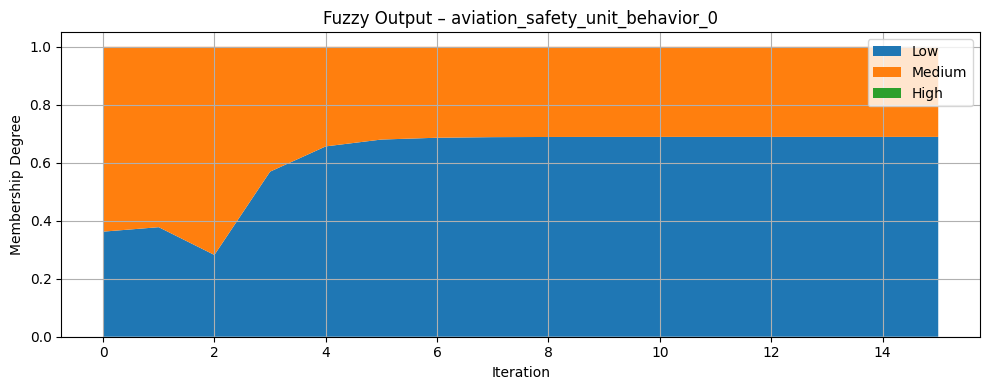

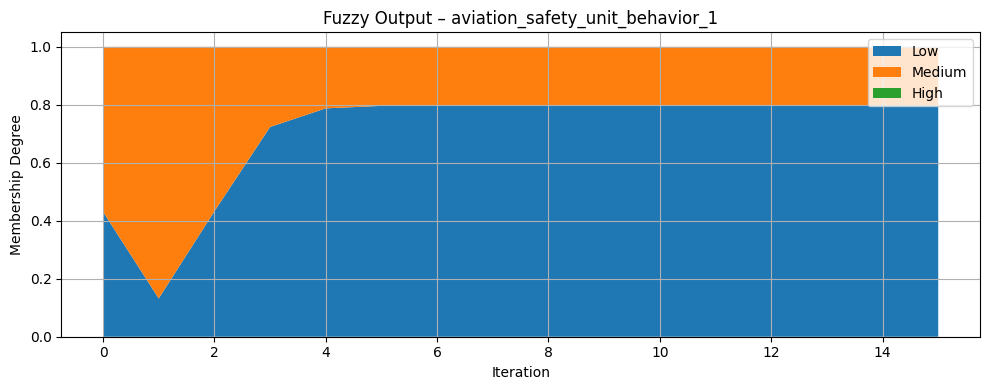

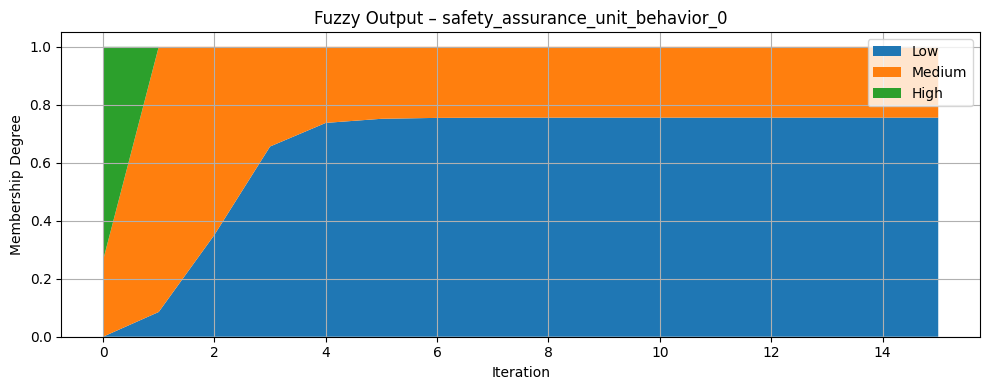

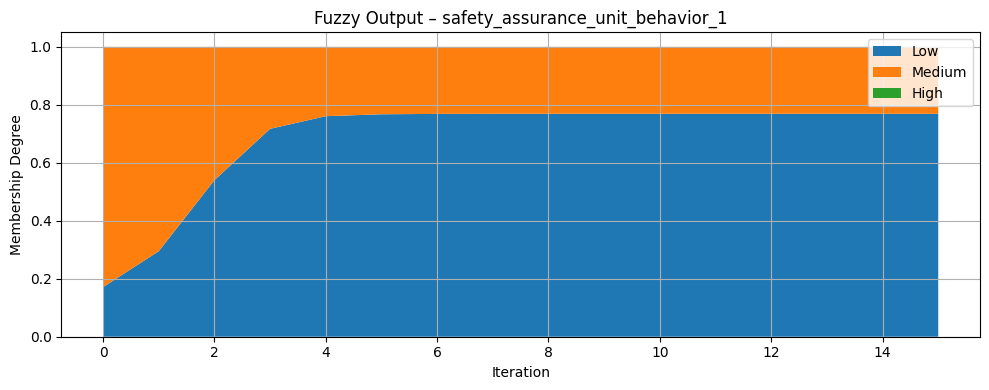

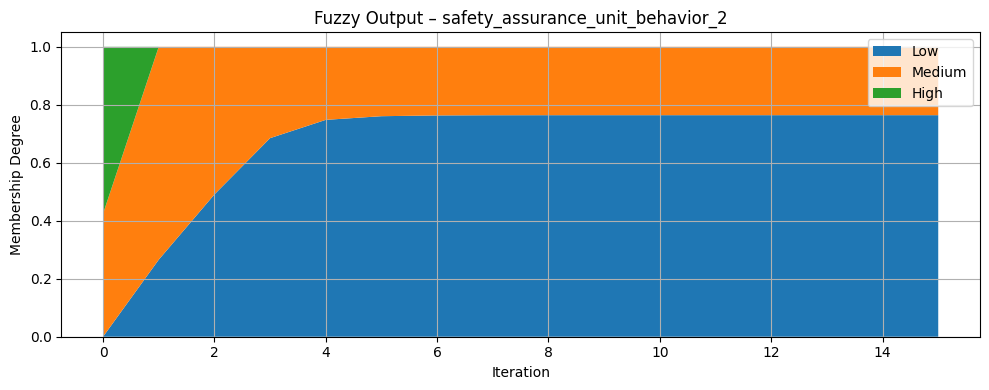

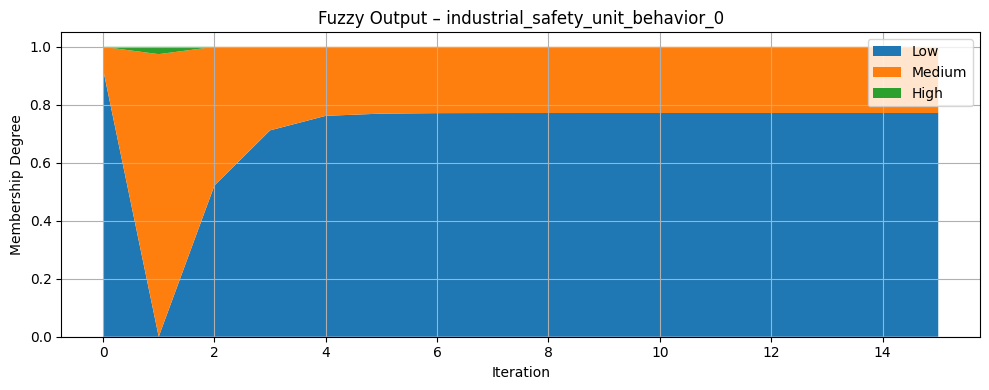

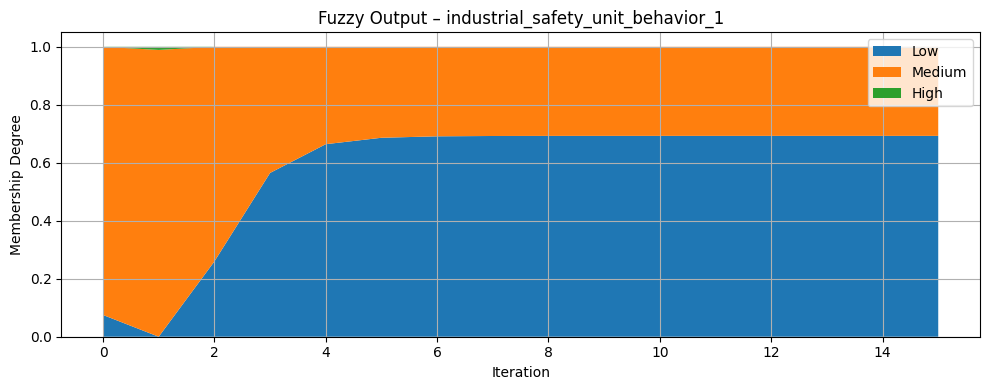

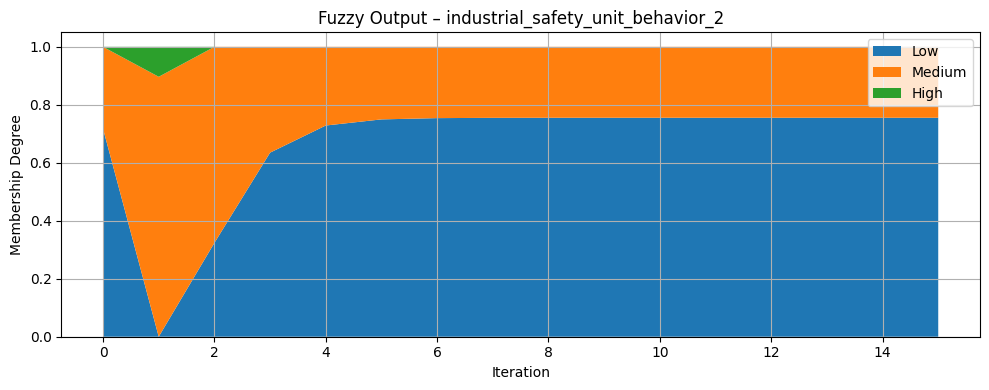

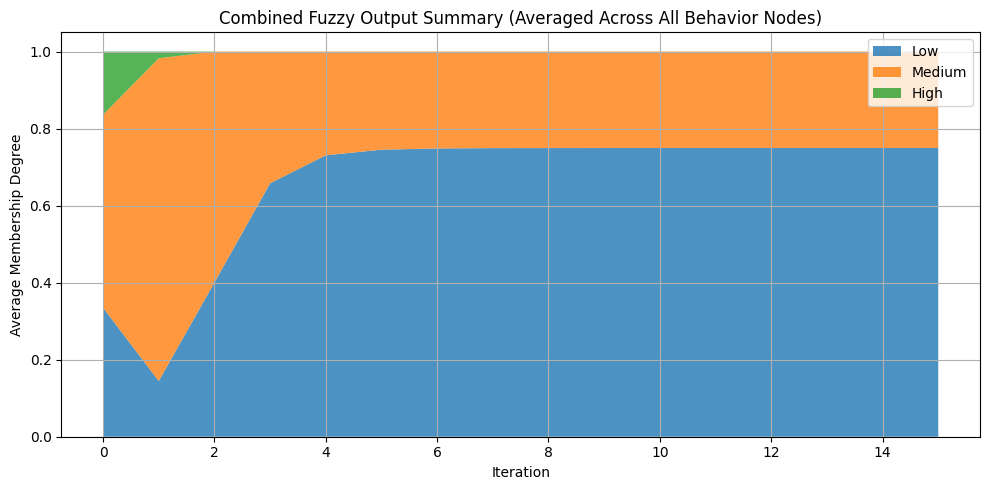

In [ ]:
individual_dfs, summary_df = display_fuzzy_output_with_summary(fuzzy_history, Output_Variable_Name)


In [ ]:
import matplotlib.pyplot as plt

def plot_aggregated_fuzzy_result(fuzzy_history, output_names):
    """
    Combines all fuzzy output nodes (last iteration) into one aggregated fuzzy vector,
    and plots it as a single horizontal bar chart.
    """

    # Step 1: Extract last fuzzy output of each output node
    combined = {'Low': 0.0, 'Medium': 0.0, 'High': 0.0}
    count = 0

    for idx in fuzzy_history:
        last_fuzzy = fuzzy_history[idx][-1]
        for level in ['Low', 'Medium', 'High']:
            combined[level] += last_fuzzy.get(level, 0)
        count += 1

    # Step 2: Normalize
    for level in combined:
        combined[level] /= count

    # Step 3: Plot
    levels = list(combined.keys())
    values = list(combined.values())

    plt.figure(figsize=(8, 2))
    bars = plt.barh(['System Estimate'], values, color=['#d62728', '#ff7f0e', '#2ca02c'], left=[0, values[0], values[0]+values[1]])
    plt.xlim(0, 1.05)
    plt.title(" Final Aggregated System Output (Fuzzy)")
    plt.xlabel("Membership Degree")
    plt.yticks([])
    plt.grid(axis='x', linestyle='--', alpha=0.5)
   #plt.legend(levels, loc='lower right')
    plt.tight_layout()
    plt.show()

    return combined


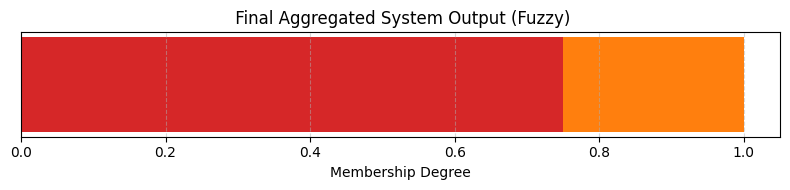

In [ ]:
aggregated_fuzzy = plot_aggregated_fuzzy_result(fuzzy_history, Output_Variable_Name)


# ✅ plot_defuzzy_node_evolution

In [ ]:

history, fuzzy_history = fcm_simulation_fuzzy_safe(
    fcm_matrix, init_state, root_nodes,
    Random_variables_list, Output_list, Output_Variable_Name,
    num_iterations=10, fuzzy_output=False     #  False for Num output ------------True for fuzzy output
)

In [ ]:
def defuzzify_history(history):
    """
    Converts fuzzy-valued history into a crisp-valued numeric history.
    Useful for plotting.

    Parameters:
    - history: list of dicts, where values can be numeric or fuzzy dicts

    Returns:
    - numeric_history: list of dicts with only numeric values (defuzzified)
    """
    numeric_history = []

    for state in history:
        numeric_state = {}
        for i, val in state.items():
            if isinstance(val, dict):
                numeric_state[i] = defuzzify(val)
            else:
                numeric_state[i] = val
        numeric_history.append(numeric_state)

    return numeric_history


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_numeric_fcm_results(numeric_history, root_nodes, random_nodes, output_nodes, output_names):
    """
    Plots 4 types of numeric simulation results:
    1. All non-root node evolutions
    2. Target output node evolutions
    3. Combined mean output evolution
    4. Final-state summary of outputs with variation
    """

    num_iterations = len(numeric_history)
    num_nodes = len(numeric_history[0])

    # ✅ 1. Plot All Non-root, Non-random Nodes
    plt.figure(figsize=(16, 8))
    for i in range(num_nodes):
        if i not in root_nodes and i not in random_nodes:
            series = [state[i] for state in numeric_history]
            plt.plot(series, label=f"Node {i}")
    plt.title("All Non-Root Node Evolutions")
    plt.xlabel("Iteration")
    plt.ylabel("Activation Level")
    plt.grid(True)
    plt.ylim(-1.1, 1.1)
    plt.tight_layout()
    plt.show()

    # ✅ 2. Plot Output Node Evolutions
    plt.figure(figsize=(12, 6))
    for i, name in zip(output_nodes, output_names):
        series = [state[i] for state in numeric_history]
        plt.plot(series, label=name)
    plt.title("Output Node Evolutions")
    plt.xlabel("Iteration")
    plt.ylabel("Activation Level")
    plt.grid(True)
    plt.legend()
    plt.ylim(-1.1, 1.1)
    plt.tight_layout()
    plt.show()

    # ✅ 3. Plot Mean Output Evolution (Combined)
    combined_series = []
    for t in range(num_iterations):
        values = [numeric_history[t][i] for i in output_nodes if isinstance(numeric_history[t][i], (int, float, np.float64))]
        mean_val = np.mean(values)
        combined_series.append(mean_val)

    plt.figure(figsize=(10, 5))
    plt.plot(combined_series, color='black', linewidth=2)
    plt.title("Combined Output Evolution (Mean Over Time)")
    plt.xlabel("Iteration")
    plt.ylabel("Average Output Activation")
    plt.grid(True)
    plt.ylim(-1.1, 1.1)
    plt.tight_layout()
    plt.show()

    # ✅ 4. Final Step – Output Distribution (Mean + Range)
    final_values = [numeric_history[-1][i] for i in output_nodes if isinstance(numeric_history[-1][i], (int, float, np.float64))]
    mean_final = np.mean(final_values)
    std_final = np.std(final_values)
    min_final = np.min(final_values)
    max_final = np.max(final_values)

    plt.figure(figsize=(8, 5))
    plt.bar(["Outputs"], [mean_final], yerr=[[mean_final - min_final], [max_final - mean_final]],
            capsize=15, color="skyblue", edgecolor="black")
    plt.title("Final Output Estimate (Mean with Range)")
    plt.ylabel("Activation Level")
    plt.ylim(-1.1, 1.1)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()


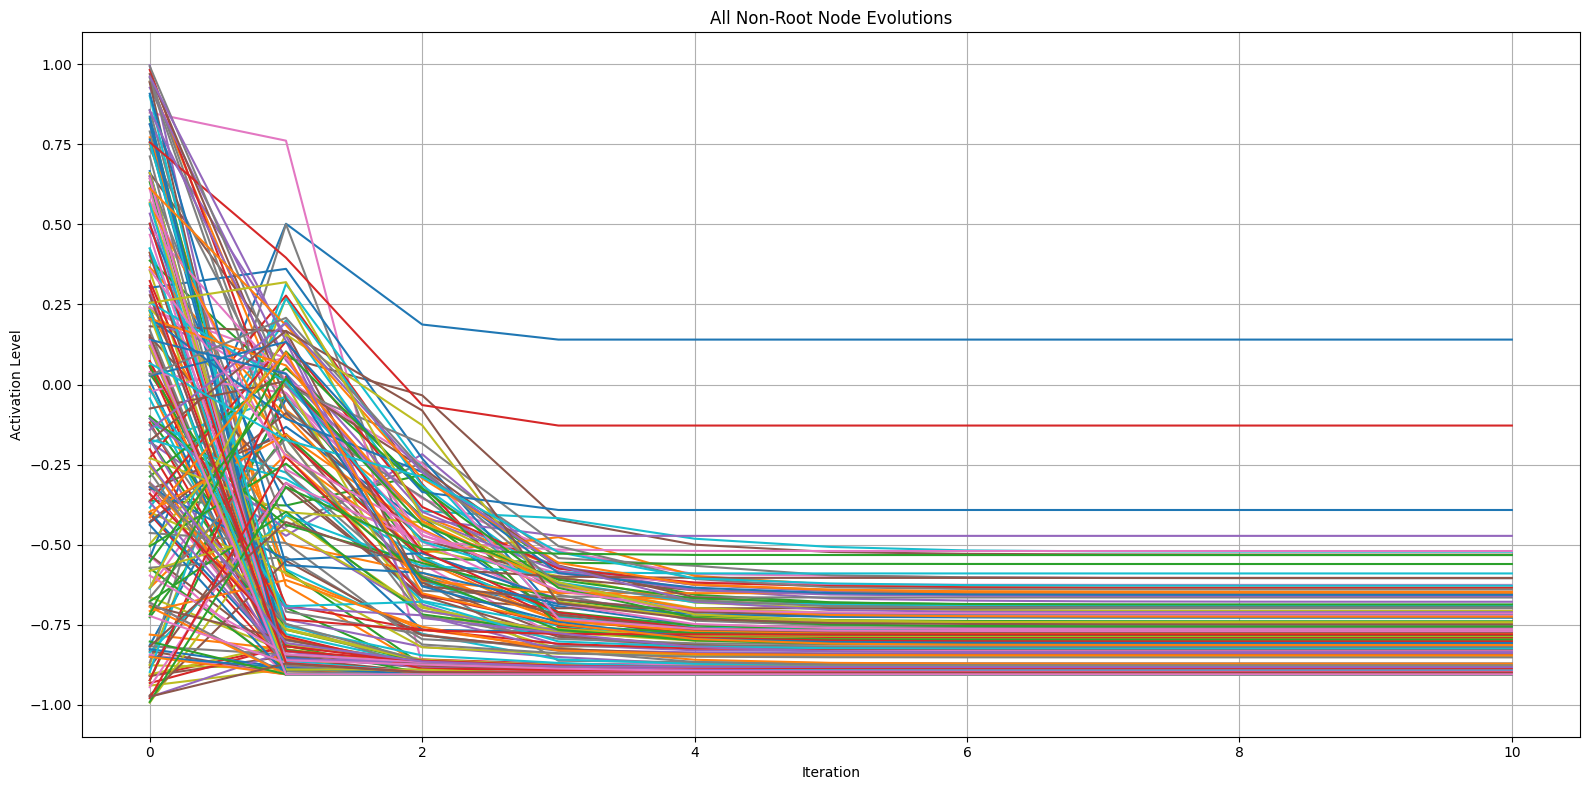

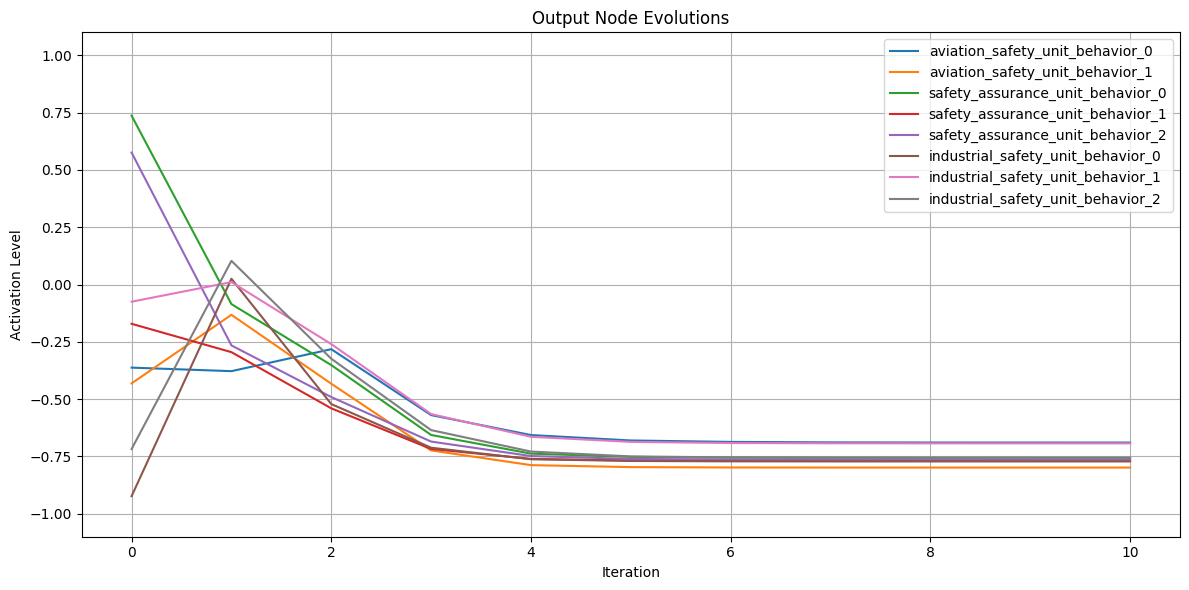

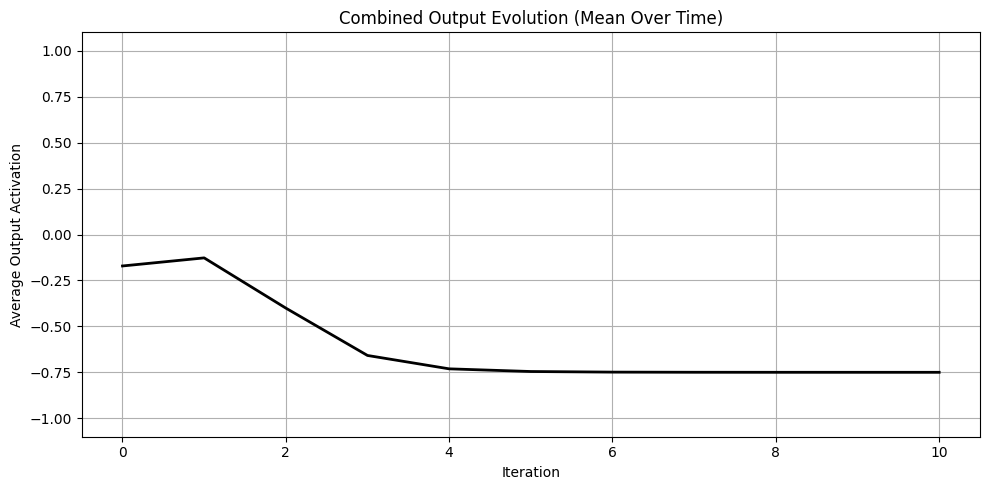

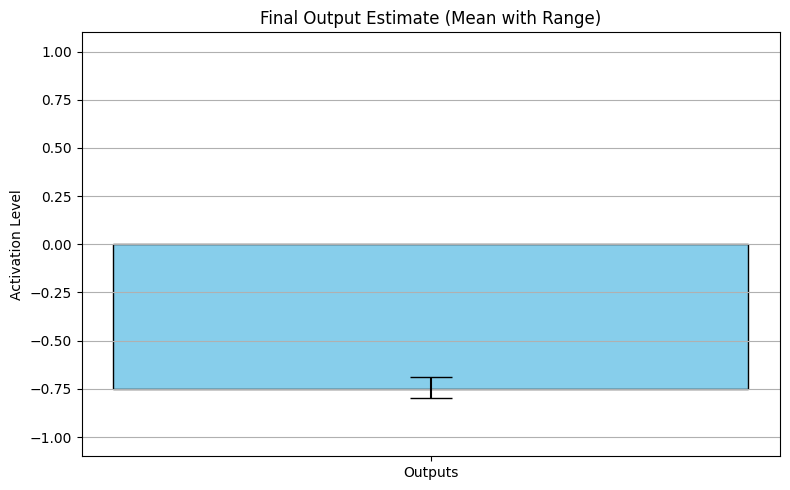

In [ ]:
numeric_history = defuzzify_history(history)

plot_numeric_fcm_results(
    numeric_history,
    root_nodes=root_nodes,
    random_nodes=Random_variables_list,
    output_nodes=Output_list,
    output_names=Output_Variable_Name
)
